# Main figure for the paper with downstream analysis - AVN, donor A61

In this notebook, we present the main downstream analysis to explore the impact of cellular niche and cellular composition on cell type specific gene expression. Here, we show the mapping, the spatial selection of the cells, the differences in GEx patters, exploration of DEGs, differences in colocalization and cell-cell communication. Moreover, we organize the notebook as the main figure of the paper. 

In [1]:
global_path = './cell-cell-communication/' ## Path to the github downloaded repository

In [2]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
import pickle
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import random
import ktplotspy as kpy
from cellphonedb.src.core.methods import cpdb_statistical_analysis_method
from collections import Counter

from sklearn.metrics import roc_curve, roc_auc_score, auc,fbeta_score, precision_score
from scipy.spatial.distance import pdist, cdist
from scipy.spatial import distance
from scipy.stats import spearmanr


import sys
sys.path.insert(1, global_path + 'Functions/')
from mapping_exploration import prepare_cytospace, abundances_figure
from downstream_analysis import pseudoreplicates, obtain_deg, compute_colocalization, run_cellphonedb
plt.rcParams['font.family'] = 'FreeSans' 
from adjustText import adjust_text
title_size = 12
labelout_size = 10
label_size = 8
ticks_size = 6

In [3]:
### heart slide
adata_sp = sc.read(global_path + 'Data/Heart/visium-OCT_AVN_lognormalised.h5ad')
adata_sp = adata_sp[adata_sp.obs.donor == 'A61']
adata_sp = adata_sp[adata_sp.obs.sangerID == 'HCAHeartST11290662']

### adata of the donor
adata = sc.read(global_path + 'Data/Heart/Global_lognormalised_AVN_A61.h5ad')


# Figure 1A: Representation of spatial mapping - CytoSPACE

Here we are representing the spatial distribution of the main cell types across the spatial slide. We first extract the counts per spot of this cells of interest, and save the coordinates of this spots for representation. Then, for representation purposes, we normalize the abundance values and select the most abundant cell per spot.  

In [4]:
cytospace_folder = global_path + 'Results/Heart/CytoSPACE/AVN/'
## Select the cells that you want to visualize in the space
query_cells = ['AVN_P_cell', 'FB4_activated', 'Adip2', 'NC2_glial_NGF']
## Compute abundances 
abundances, coords = prepare_cytospace(cytospace_folder, query_cells)

findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans'

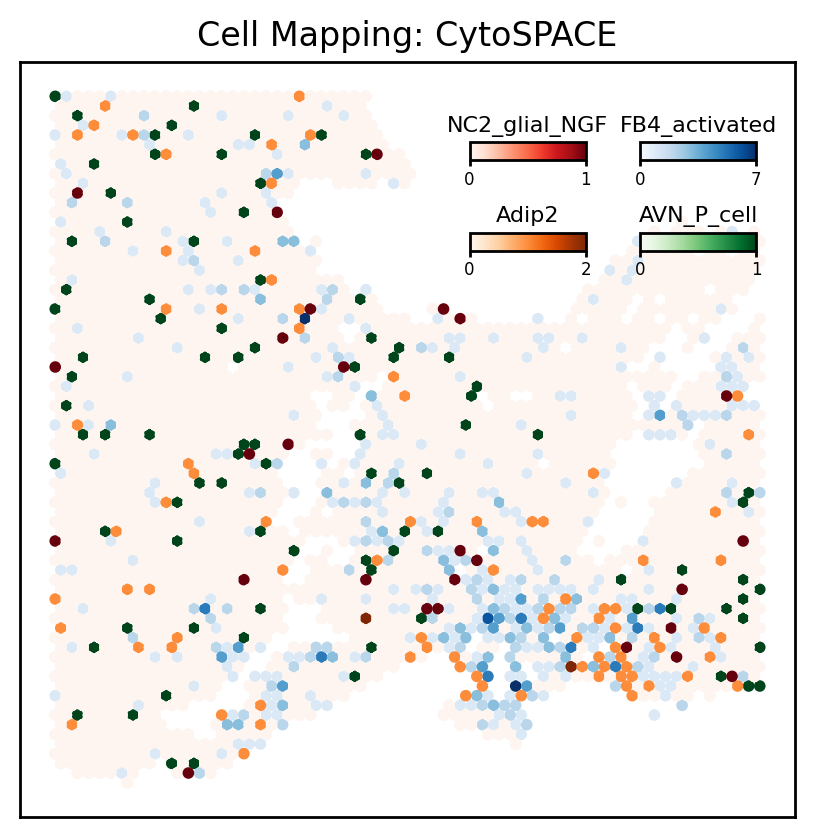

In [5]:
## Inicialize figure
fig, ax_scatter = plt.subplots(figsize=(5,5), dpi=200)

## Define colorbar bounds
colorbar_bounds = [
    [0.8, 0.1+0.65, 0.15, 0.024],  # Bottom right corner, first column
    [0.8, 0.1+0.65+0.12, 0.15, 0.024],   # Second row
    [0.58, 0.1+0.65, 0.15, 0.024],  # First column, one row above
    [0.58, 0.1+0.65+0.12, 0.15, 0.024],   # Second row
]

# Figure
abundances_figure(abundances, coords, ax_scatter, query_cells, 'Cell Mapping: CytoSPACE', colorbar = True, colorbar_bounds = colorbar_bounds)



# Categorize selected cell type into distinct groups based on their spatial position

Once we have explore the mapping result, we can select a cell type of interest, in our case **Fibroblasts 4 activated** and identify distinct spatial regions to assign these cells, and explore how variations in cellular composition affect the gene expression of the cell of interest and communication dynamics. In this example we are going to compare FB4_activated that are present in differnt histological regions (node and myocardium_ventricular)

In [6]:
## output CytoSPACE 
cyto_cell2spot = pd.read_csv(cytospace_folder + 'assigned_locations.csv') # Each individual cell assigned to which spot
cyto_spot2cell = pd.read_csv(cytospace_folder + 'cell_type_assignments_by_spot.csv') # For each spot, which cells types are assigned to it (quantity)
del(cyto_spot2cell['Total cells']) ## remove total cells column

### Obtain spot region according to the annotation of the slides
cyto_cell2spot['region'] = [adata_sp.obs[adata_sp.obs.index == i].annotation_final[0] for i in cyto_cell2spot.SpotID]
### Select real cells (at it was run using placeholders)
cyto_cell2spot = cyto_cell2spot.dropna(subset = 'OriginalCID')
# ### Select cell of interest that are present in the region of interest
fb4_cyto = cyto_cell2spot[cyto_cell2spot.CellType == 'FB4_activated']
fb4_cyto = fb4_cyto[fb4_cyto.region.isin(['node', 'myocardium_ventricular'])]

findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans'

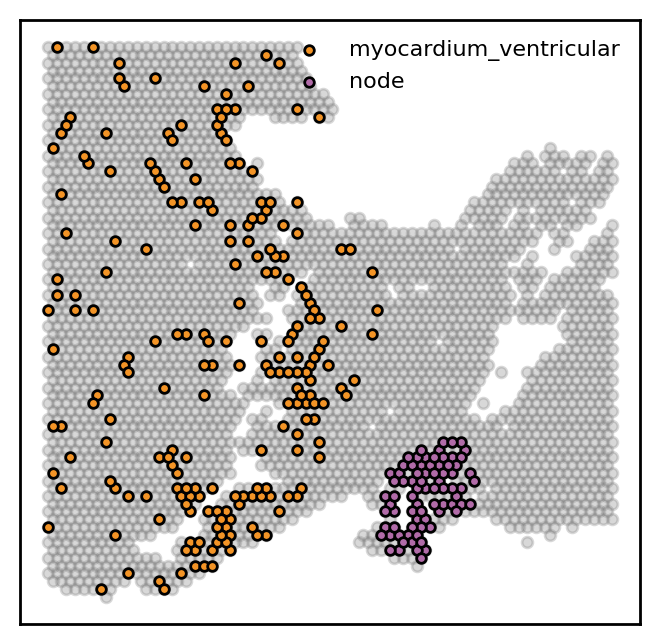

In [7]:
## Subset the dataframe and split it into the two spatial groups

myo_cells = fb4_cyto[fb4_cyto.region == 'myocardium_ventricular']
node_cells = fb4_cyto[fb4_cyto.region == 'node']

# Check the distribution of cells according to the division
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4,4), dpi = 200)

### Background coordinates of the annotations
xs = adata_sp.obs.array_row.values
ys = adata_sp.obs.array_col.values
axs.scatter(ys, -xs, s=15, c= 'grey', alpha = 0.3)

### Coordinates of the fibroblasts
coords_fibro_epi = fb4_cyto[fb4_cyto.region == 'myocardium_ventricular'][['row', 'col']].drop_duplicates()
coords_fibro_myo = fb4_cyto[fb4_cyto.region == 'node'][['row', 'col']].drop_duplicates()

axs.scatter(coords_fibro_epi.col, -coords_fibro_epi.row, s=12,  color = '#F39426',edgecolors = 'black', label='myocardium_ventricular', alpha=1)
axs.scatter(coords_fibro_myo.col, -coords_fibro_myo.row, s=12,  color = '#B16BA8',edgecolors = 'black', label='node', alpha=1)
axs.set_xlabel('')
axs.set_ylabel('')
axs.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.legend(frameon=False, loc = 'upper right',  fontsize = label_size)

Once we have defined the groups of cells based on spatial location, we can start with downstream analysis to explore differences in their GEx and communication dynamics

# Figure 1C: Distances between FB4 in same locations vs different locations

Explore the overall differences in GEx profiles in relation to cell spatial locations computing pairwise cosine distances between log-normalized GEx vectors. 

In [8]:
############## Select ids according to location ###############
# select the id of the cells according to the location and select a random background background
# We need to select the ids for obtaining the expression from the adata_ref
id_loc1 = fb4_cyto[fb4_cyto.region == 'node'].OriginalCID.unique()
id_loc2 = fb4_cyto[fb4_cyto.region == 'myocardium_ventricular'].OriginalCID.unique()
random_bk = np.random.choice(adata.obs.index, len(fb4_cyto.OriginalCID.unique()), replace = False)


In [9]:
############# Distances according to location #############
# select the GEX of the spots
GEX_loc1 = adata[adata.obs.index.isin(id_loc1)].X.toarray()
GEX_loc2 = adata[adata.obs.index.isin(id_loc2)].X.toarray()
GEX_cancer = adata[adata.obs.index.isin(fb4_cyto.OriginalCID.unique())].X.toarray()
GEX_bk = adata[adata.obs.index.isin(random_bk)].X.toarray()

# calculate the distances
loc1_cosine = pdist(GEX_loc1, 'cosine')
loc2_cosine = pdist(GEX_loc2, 'cosine')
all_cosine = pdist(GEX_bk, 'cosine')
all_cosine_cancer = pdist(GEX_cancer, 'cosine')
vs_cosine = cdist(GEX_loc1, GEX_loc2, 'cosine')


In [10]:
print('Mean cosine distance between cancer cells in Node: %s \nMean cosine distance between cancer cells in Myocardium: %s \nMean cosine distance between cells in diferent locations: %s'%(np.mean(loc1_cosine), np.mean(loc2_cosine), np.mean(np.concatenate(vs_cosine))))

Mean cosine distance between cancer cells in Node: 0.701051584002245 
Mean cosine distance between cancer cells in Myocardium: 0.7115526257145729 
Mean cosine distance between cells in diferent locations: 0.7082245789175204


Text(0.5, 1.0, 'Distribution of GEx distances')

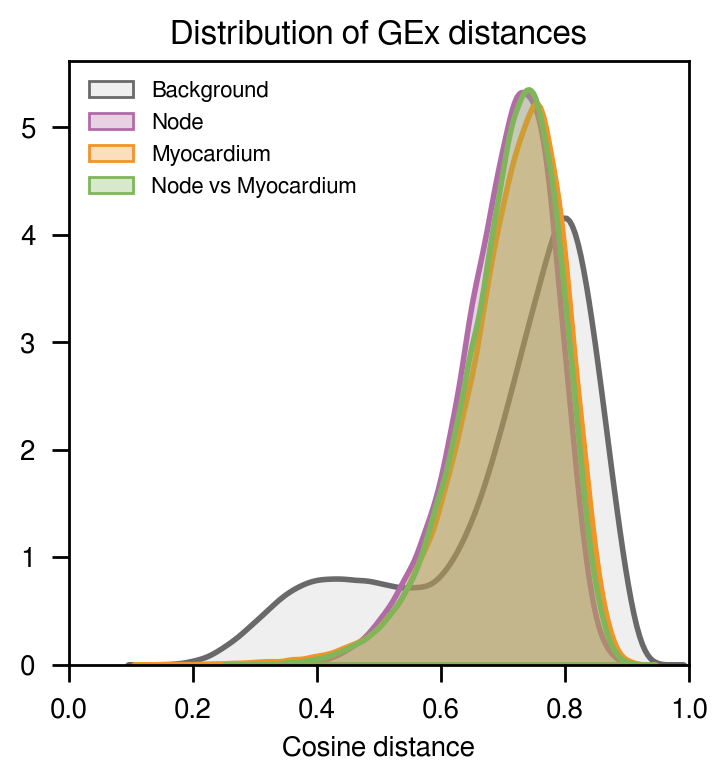

In [11]:

fig, axs = plt.subplots(figsize=(4, 4), dpi = 200)

sns.kdeplot(all_cosine, label = 'Background', color = 'dimgray', ax = axs, fill=True, alpha=.1,  linewidth=2)
sns.kdeplot(loc1_cosine, label = 'Node', color = '#B16BA8' ,ax = axs, fill=True, alpha=.3, linewidth=2)
sns.kdeplot(loc2_cosine, label = 'Myocardium', color = '#F39426', ax = axs, fill=True,  alpha=.3,linewidth=2)
sns.kdeplot(np.concatenate(vs_cosine), label = 'Node vs Myocardium', color = '#80b55a', fill=True, alpha = 0.3,linewidth=2)


legend = axs.legend(frameon = False, fontsize = label_size, loc= 'upper left')
for handle in legend.legend_handles:
    handle.set_linewidth(1) 

axs.set_xlim(0,1)
axs.set_xlabel('Cosine distance', fontsize=labelout_size)
axs.set_ylabel('')
axs.tick_params(axis='both', which='major', labelsize=labelout_size)
axs.set_title('Distribution of GEx distances', fontsize=title_size)


We are not able to see differences between the groups at overall GEX level. 

# Figure 1E: Volcano plot

In [19]:
## Subset anndata and add the cell group to the adata object
adata_fb = adata[adata.obs.index.isin(fb4_cyto.OriginalCID.unique())]
adata_fb.obs['cluster'] = [fb4_cyto[fb4_cyto.OriginalCID == i].region.values[0] for i in adata_fb.obs.index]
adata_fb.obs.groupby('cluster')['cluster'].count()
adata_fb.uns['log1p']["base"] = None ## Prevent an error when using this function
adata_fb.var_names_make_unique()

### For running pseudobulk I need raw data and it is not present in the same object as layer. 
adata_raw = sc.read(global_path + 'Data/Heart/RNA_adult-8reg_full_raw_cellstate-annotated.h5ad')
adata_raw = adata_raw[adata_raw.obs.index.isin(adata_fb.obs.index)]
adata_raw.obs['cluster'] = adata_fb.obs.cluster


In [20]:
## Build the adata object for the pseudoreplicates
pb = pseudoreplicates(adata_raw, 'cluster', n = 3, layer = '')
## Obtain the DEG
loc1vsloc2 = obtain_deg(pb,'node', 'myocardium-ventricular')

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 11.00 seconds.

Fitting dispersion trend curve...
... done in 9.77 seconds.

/home/epareja/miniconda3/envs/cpdb_v4/lib/python3.8/site-packages/pydeseq2/dds.py:619: RuntimeWarning: invalid value encountered in log
Fitting MAP dispersions...
... done in 16.16 seconds.

/home/epareja/miniconda3/envs/cpdb_v4/lib/python3.8/site-packages/pydeseq2/dds.py:687: RuntimeWarning: invalid value encountered in log
Fitting LFCs...
... done in 4.93 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: condition node vs myocardium-ventricular
                  baseMean  log2FoldChange     lfcSE      stat    pvalue   
ENSG00000237491   6.583602        0.168803  0.624129  0.270461  0.786806  \
ENSG00000225880   0.531875       -1.948100  2.104773 -0.925563  0.354673   
ENSG00000230368   0.110004        0.268967  2.378246  0.113095  0.909955   
ENSG00000272438   0.318014        1.230762  2.061440  0.597040  0.550481   
ENSG00000223764   0.338438        1.230762  2.064983  0.596016  0.551165   
...                    ...             ...       ...       ...       ...   
ENSG00000276256   2.558537       -0.692581  0.914105 -0.757660  0.448655   
ENSG00000273748  13.174347        0.133376  0.461861  0.288779  0.772751   
ENSG00000278817   0.543177       -0.244830  1.735915 -0.141038  0.887840   
ENSG00000278384   3.304620       -0.890685  0.908244 -0.980667  0.326757   
ENSG00000271254   1.282018        0.489123  1.190664  0.410799  0.681220   

        

... done in 2.28 seconds.



In [21]:
ensg2sym = dict(zip(adata_raw.var.index, adata_raw.var['gene_name-new']))
loc1vsloc2['symbol'] = [ensg2sym[i] for i in loc1vsloc2.index]

## Select significant DEGs adjusted p-value < 0.05 and log2FC > 1
loc1vsloc2.reset_index(inplace = True)
loc1vsloc2_sig = loc1vsloc2[loc1vsloc2.padj < 0.05]
loc1vsloc2_sig = loc1vsloc2_sig[abs(loc1vsloc2_sig.log2FoldChange) > 1]

In [23]:
loc1vsloc2.sort_values('padj', inplace = True)  


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


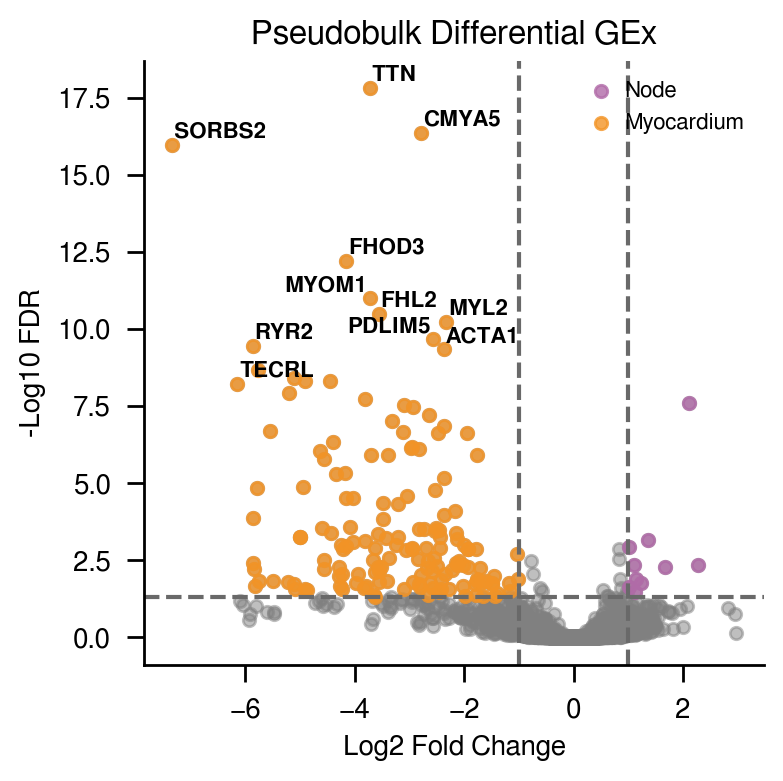

In [15]:
##### Select genes for the volcano plot text #####
# Select the top 5 up and down regulated genes 
top_dw = loc1vsloc2.sort_values('log2FoldChange').head(5)
top_up = loc1vsloc2.sort_values('log2FoldChange').tail(5)
top_all = top_dw.merge(top_up, how = 'outer')
# Select the genes with the lowest p-values
top_pval = loc1vsloc2_sig.sort_values('padj', ascending = True).head(10)

##### Create the volcano plot ####

# Transform data for plotting
log_fold_changes = loc1vsloc2.log2FoldChange.values      # Log2 fold change
neg_log_p_values = -np.log10(loc1vsloc2.padj.values)        # -Log10 p-value

fig = plt.figure(figsize=(4,4), dpi = 200)

# Scatter plot specifying points of interest
# Let's say significant points are those with abs(log fold change) > 1 and -log p-value > 1.5
plt.scatter(log_fold_changes, neg_log_p_values, color='grey', alpha=0.5, s = 20)
plt.scatter(log_fold_changes[(log_fold_changes > 1) & (neg_log_p_values > -np.log10(0.05))], 
            neg_log_p_values[(log_fold_changes > 1) & (neg_log_p_values > -np.log10(0.05))], 
            color='#B16BA8', alpha=0.8, s= 20, label = 'Node')

plt.scatter(log_fold_changes[(log_fold_changes < -1) & (neg_log_p_values > -np.log10(0.05))], 
            neg_log_p_values[(log_fold_changes < -1) & (neg_log_p_values > -np.log10(0.05))], 
            color='#F39426', alpha=0.8, s= 20, label = 'Myocardium')

# Add gene names for the top genes
texts = []
for index, row in top_pval.iterrows():
        texts.append(plt.text(row['log2FoldChange'], -np.log10(row['padj']), row['symbol'], fontsize=label_size, fontweight = 'bold'))

for index, row in top_all.iterrows():
        if row['padj'] > 0.05:
                continue
        if row['symbol'] not in top_pval['symbol'].tolist():
                texts.append(plt.text(row['log2FoldChange'], -np.log10(row['padj']), row['symbol'], fontsize=label_size, fontweight = 'bold'))
try:
        adjust_text(texts)
except:
        print('No DEGs')

# Highlighting the threshold line for p-value
plt.axhline(y=-np.log10(0.05), color='dimgray', linestyle='--')
plt.axvline(x=1, color='dimgray', linestyle='--')
plt.axvline(x=-1, color='dimgray', linestyle='--')


# Add labels and title
plt.xlabel('Log2 Fold Change', fontsize=labelout_size)
plt.ylabel('-Log10 FDR', fontsize=labelout_size)
plt.title('Pseudobulk Differential GEx', fontsize=title_size)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.tick_params(axis='both', which='major', labelsize=labelout_size)
plt.legend(frameon = False, fontsize = label_size, handlelength=0.5, loc = 'upper right')



We found a lot of differentially expressed genes across the FB4 located in the different histological regions

# Figure 1D: Co-localization vs cell-cell interactions

We wanted to correlate colocalization with cell-cell interactions as it is expected that colocalizing cells would be more likely to interact. So the idea was to use the colocalization patterns to evaluate the prediction of the intercellular communication. 

## Colocalization calculation 

For defining the different spatial groups, we visually looked at mapping results. But we eanted to quantify this spatial colocalization of different cell types. We compute the binary matrix to represent the spot profile of each cell type and then, we compute Jaccard similarities, with higer JS indicating a higher colocalization (cell types tend to be in same spots)

In [9]:
# Select the unique spots where each of the cancer cells are present
loc1_spots = node_cells.SpotID.unique()
loc2_spots = myo_cells.SpotID.unique()

# Compute the colocalization between cancer cells in the two locations and the rest of the cells in the dataset
closest_cells_df = compute_colocalization(cytospace_folder, 'FB4_activated', loc1_spots, loc2_spots)

## CellphoneDB results

For the analysis of intercellular communication, we mostly use CellPhoneDB (one of the core tools for studiyng this communication). We prepared the log-normalized counts and metadata relating cell barcodes to the previously defined cell types (including our division of FB4 by region). This division allows us to explore differences in communication between same cellular types in different localization surrounded by different cells. 

In [10]:
# Files to run cellphonedb
meta_file_path = global_path + 'Data/Heart/Input_CP/AVN_metadata_cancer_region_ass.tsv'
counts_file_path = global_path + 'Data/Heart/Input_CP/AVN_adata_cancer_region_ass.h5ad'
out_path = global_path + 'Results/Heart/CellPhoneDB/AVN/'
cpdb_file_path = global_path + 'Data/cellphonedb.zip' # CellPhoneDB file (downloaded from their github)

In [18]:
# Prepare data to run cellphonedb

adata = adata[adata.obs.index.isin(cyto_cell2spot.OriginalCID.unique())] # select only the cells that have been mapped by cytoSPACE

## Create a new column in the adata object with the cell type according to the location
celltype_loc = []
for i in adata.obs.index: 
    if i in fb4_cyto['OriginalCID'].tolist():
        celltype_loc.append(fb4_cyto[fb4_cyto['OriginalCID'] == i].region.values[0])
    else: 
        celltype_loc.append(cyto_cell2spot[cyto_cell2spot['OriginalCID'] == i].CellType.values[0])

adata.obs['celltype_loc'] = celltype_loc

## Create the meta dataframe for the cellphonedb
meta_cp = pd.DataFrame([adata.obs.index,adata.obs['celltype_loc']]).T
meta_cp.columns = ['Cell', 'cell_type']

meta_cp.to_csv(meta_file_path, sep= '\t')
adata.write(counts_file_path)

... storing 'celltype_loc' as categorical


In [11]:
# Run cellphonedb
pval = global_path + 'Results/Heart/CellPhoneDB/AVN/statistical_analysis_pvalues_08_26_2024_19:58:47.txt'
counts_qcell = run_cellphonedb(cpdb_file_path, meta_file_path, counts_file_path, out_path, 'celltype_loc', ['node', 'myocardium_ventricular'], pval)

/aloy/home/epareja/2022/single_cell/paper_folders/Functions/downstream_analysis.py:291: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.


## Select cells for representation 

In [12]:
top_bottom_CC = ['Adip2', 'NC2_glial_NGF+',  'B_plasma',  'CD8+T_te']
top_bottom_coloc = ['FB5', 'FB3', 'EC1_cap', 'LYVE1+TIMD4+MP']

In [13]:
# Subset cellphonedb and colocalization results to explore some cells of interest (representation purposes)
selected_CC = counts_qcell[counts_qcell.index.isin(np.concatenate([top_bottom_CC, top_bottom_coloc]))]
selected_coloc = closest_cells_df[closest_cells_df.cells.isin(np.concatenate([top_bottom_CC, top_bottom_coloc]))]
selected_coloc.sort_values('cells', inplace = True)
selected_coloc.set_index('cells', inplace = True)

# Merge the two dataframes
data_cc_coloc = selected_CC.merge(selected_coloc, left_index = True, right_index = True)
data_cc_coloc.reset_index(inplace = True)
data_cc_coloc.columns = ['cells', 'inter_loc1', 'inter_loc2', 'JS_loc1', 'JS_loc2']


<ipython-input-13-55dcb8248edf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Figure colocalization vs cell-cell communication

In this figure, we are representing colocalization and cell-cell communication results in the same plot to facilitate their comparison. Dotted line represent jaccard similarities and plain line number of LR interactions detected between fibroblasts and cell in the y-axis

findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans'

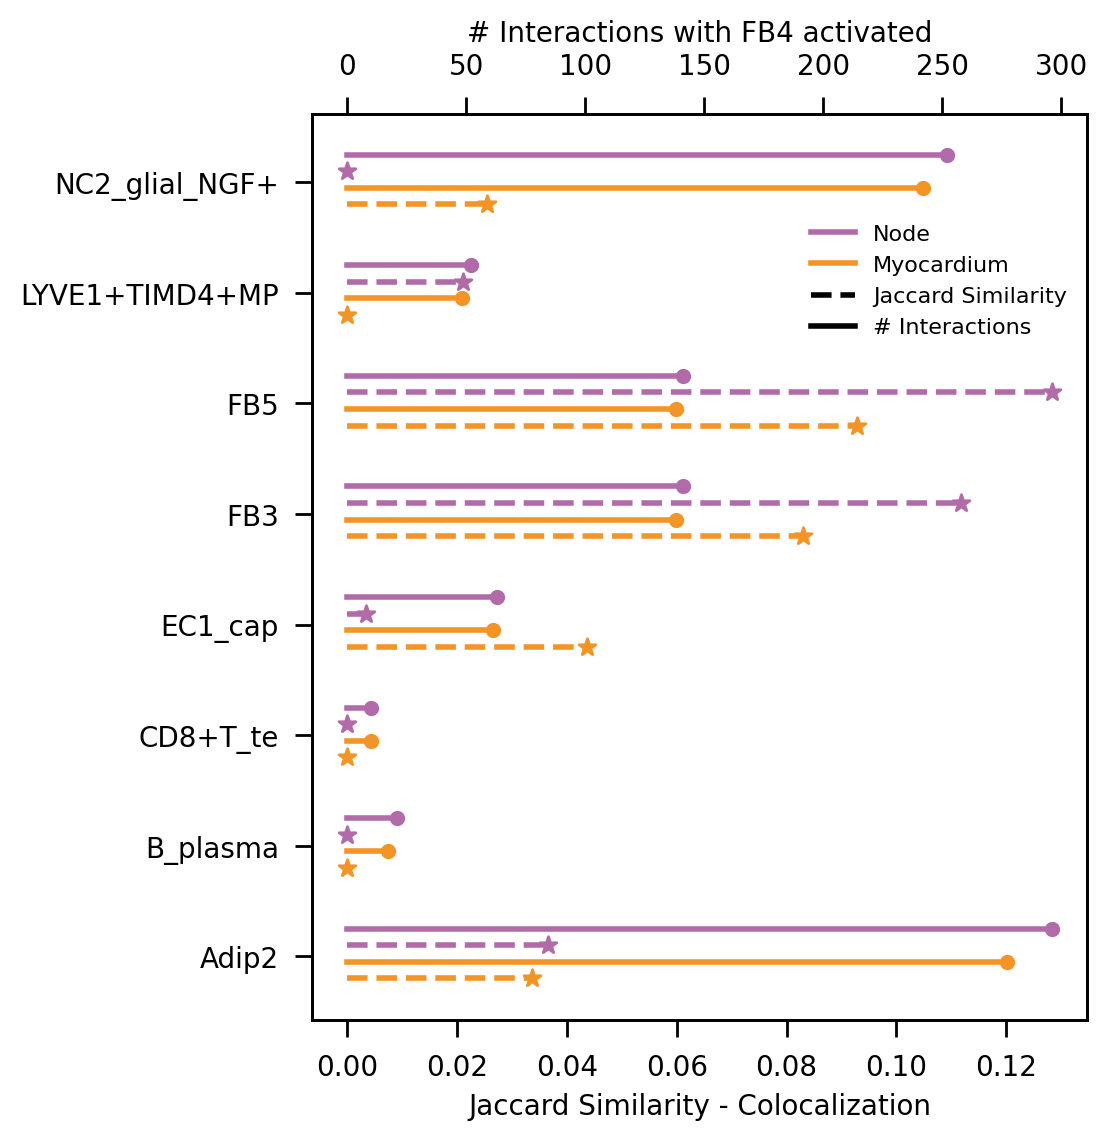

In [14]:
data = data_cc_coloc

# Create the plot
fig, ax = plt.subplots(figsize=(5,6), dpi=200)


# Plot the jaccard similarities as horizontal lolliplots
for i, row in data.iterrows():

    ax.plot([0, row['JS_loc2']], [i, i], color='#F39426', lw=2, ls = '--', zorder=10)
    ax.scatter([row['JS_loc2']], [i], color='#F39426', s=40, marker='*', zorder=10)

    ax.plot([0, row['JS_loc1']], [i + 0.3, i + 0.3], color='#B16BA8', lw=2, ls = '--', zorder=10)
    ax.scatter([row['JS_loc1']], [i + 0.3], color='#B16BA8', s=40,  marker='*', zorder=10)
    
# Create a second x-axis to represent the interactions with cancer cells
ax2 = ax.twiny() 

# Plot the number of significant LR interctions as horizontal lolliplots
for i, row in data.iterrows():
    ax2.plot([0, row['inter_loc2']], [i + 0.15, i + 0.15], color='#F39426', lw=2, zorder=10)
    ax2.scatter([row['inter_loc2']], [i + 0.15], color='#F39426', s=20, zorder=10)

    ax2.plot([0, row['inter_loc1']], [i + 0.45, i + 0.45], color='#B16BA8', lw=2, zorder=10)
    ax2.scatter([row['inter_loc1']], [i + 0.45], color='#B16BA8', s=20, zorder=10)
    

ax.set_yticks([0.2, 1.2, 2.2, 3.2, 4.2, 5.2, 6.2, 7.2], data['cells'], fontsize = labelout_size)


ax.set_xlabel('Jaccard Similarity - Colocalization',  fontsize=labelout_size)
ax2.set_xlabel('# Interactions with FB4 activated',  fontsize=labelout_size)

axs.tick_params(axis='both', labelsize=labelout_size)



from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='#B16BA8', lw=2, label='Node'),
    Line2D([0], [0], color='#F39426', lw=2, label='Myocardium'),
    Line2D([0], [0], color='black', lw=2, ls='--', label='Jaccard Similarity'),
    Line2D([0], [0], color='black', lw=2, label='# Interactions')
]
ax.legend(handles=legend_elements, fontsize=label_size, frameon = False, loc = 'upper right', bbox_to_anchor=(1, 0.9))



This plot show the disagreement between the cells that are in similar regions of the spots and the number of predicted LR interactions between them. There are some cases, for example with NC2 glial, the fibroblast in the node never colocalize but the number of interactions predicted is very high. But also we can see some correct results as in the case of B plasma or T cells in which the number of predicted interactions is very low and there is no colocalization

### Additional: explore common spots between the FB4 and other cells

findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans'

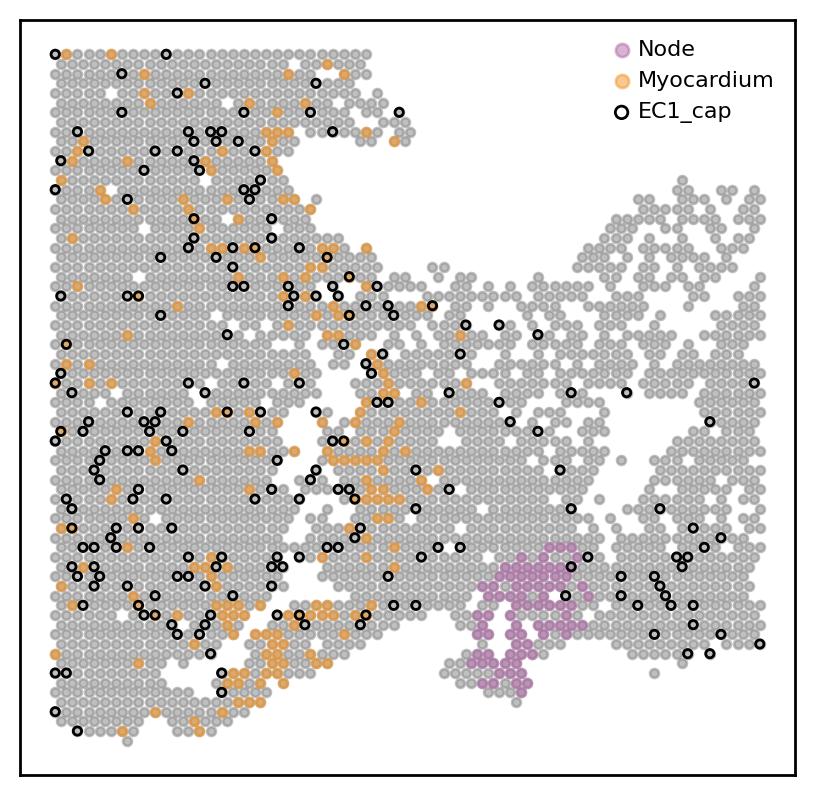

In [15]:
## check jaccard results
c = 'EC1_cap'
# Select only the spots were there are any cancer cell
spots_cell = cyto_spot2cell[cyto_spot2cell[c] > 0].SpotID.tolist()
## Select the coordinates where you can find the cancer cells from the other output file (cell2spot)
cell_coords = cyto_cell2spot[cyto_cell2spot.SpotID.isin(spots_cell)].drop_duplicates('SpotID')[['SpotID', 'row', 'col']]
background_coords = cyto_cell2spot.drop_duplicates('SpotID')[['SpotID', 'row', 'col']]

## Plot the results
fig = plt.subplots(figsize=(5,5), dpi = 200)

xs_b = background_coords.row.values
ys_b = background_coords.col.values

xs_e = cell_coords.row.values
ys_e = cell_coords.col.values

xl = fb4_cyto[fb4_cyto.SpotID.isin(fb4_cyto[fb4_cyto.region == 'myocardium_ventricular'].SpotID.unique())].drop_duplicates('SpotID')[['SpotID', 'row', 'col']].row.values
yl = fb4_cyto[fb4_cyto.SpotID.isin(fb4_cyto[fb4_cyto.region == 'myocardium_ventricular'].SpotID.unique())].drop_duplicates('SpotID')[['SpotID', 'row', 'col']].col.values

xr = fb4_cyto[fb4_cyto.SpotID.isin(fb4_cyto[fb4_cyto.region == 'node'].SpotID.unique())].drop_duplicates('SpotID')[['SpotID', 'row', 'col']].row.values
yr = fb4_cyto[fb4_cyto.SpotID.isin(fb4_cyto[fb4_cyto.region == 'node'].SpotID.unique())].drop_duplicates('SpotID')[['SpotID', 'row', 'col']].col.values

plt.scatter(ys_b, -xs_b, s=10, c = 'grey', alpha = 0.5)
plt.scatter(yr, -xr, s=10, c = '#B16BA8', alpha = 0.5, label = 'Node')
plt.scatter(yl, -xl, s=10, c = '#F39426', alpha = 0.5, label = 'Myocardium')
plt.scatter(ys_e, -xs_e, s=9, facecolor='none', edgecolors='black', label = c)
plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.legend(frameon = False,  markerscale=1.5,handlelength=0.5,  handletextpad=0.5, fontsize = 8, loc = 'upper right')

# Figure 1 F: Correlation between colocalization and CCC

Finally, we will compute the correlation between the most colocalizated cells with FB4 and the most interacting cells, to see if we find any relationship

In [16]:
## Merge the two result dataframes dataframes
data_correlation = counts_qcell.merge(closest_cells_df, left_index = True, right_on = 'cells')
data_correlation.set_index('cells', inplace = True)
data_correlation.columns = ['inter_loc1', 'inter_loc2', 'JS_loc1', 'JS_loc2']
data_correlation = data_correlation.astype(float)

Text(0.5, 1.0, 'Correlation between colocalization \n and number of LR interactions')

findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans'

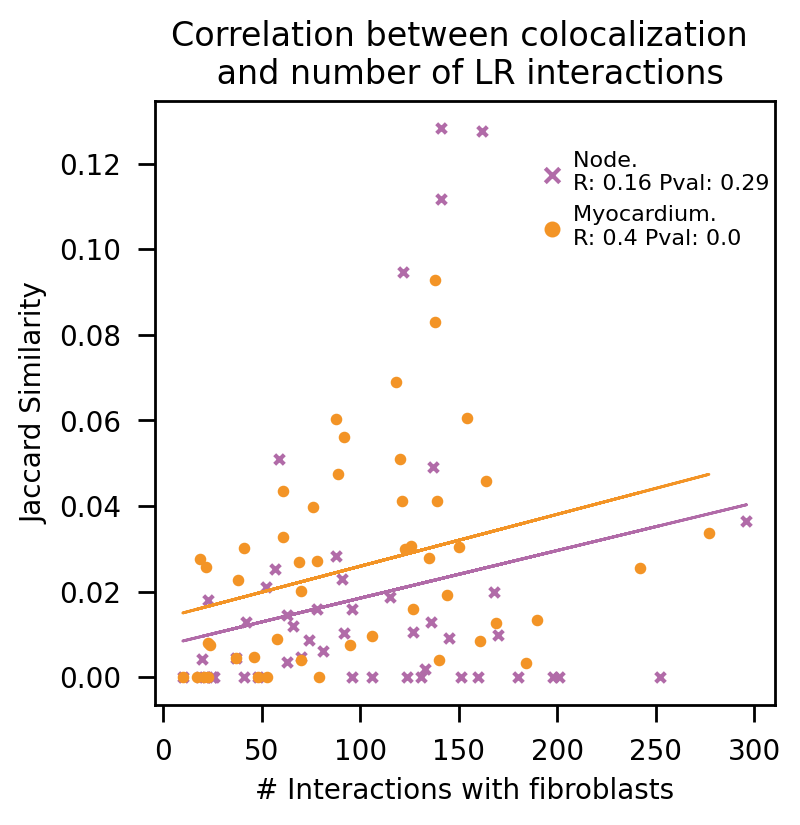

In [17]:
fig, axs = plt.subplots(1, figsize=(4, 4), dpi=200)

axs.scatter(data_correlation['inter_loc1'], data_correlation['JS_loc1'], c = '#B16BA8', s = 12, marker='x', label='Node. \nR: %s Pval: %s' % (round(spearmanr(data_correlation['inter_loc1'], data_correlation['JS_loc1'])[0], 2), round(spearmanr(data_correlation['inter_loc1'], data_correlation['JS_loc1'])[1], 2)))
axs.scatter(data_correlation['inter_loc2'], data_correlation['JS_loc2'], c ='#F39426', s=10 , label='Myocardium. \nR: %s Pval: %s' % (round(spearmanr(data_correlation['inter_loc2'], data_correlation['JS_loc2'])[0], 2), round(spearmanr(data_correlation['inter_loc2'], data_correlation['JS_loc2'])[1], 2)))
# Calculate and plot regression line for 'inter_loc1' vs. 'JS_loc1'
m_red, b_red = np.polyfit(data_correlation['inter_loc1'], data_correlation['JS_loc1'], 1)
axs.plot(data_correlation['inter_loc1'], m_red * data_correlation['inter_loc1'] + b_red, color='#B16BA8', linewidth=1)
# Calculate and plot regression line for 'inter_loc2' vs. 'JS_loc2'
m_orange, b_orange = np.polyfit(data_correlation['inter_loc2'], data_correlation['JS_loc2'], 1)
axs.plot(data_correlation['inter_loc2'], m_orange * data_correlation['inter_loc2'] + b_orange, color='#F39426', linewidth=1)

plt.ylabel('Jaccard Similarity', fontsize=labelout_size)
plt.xlabel('# Interactions with fibroblasts', fontsize=labelout_size)
plt.tick_params(axis='both', which='major', labelsize=labelout_size)
plt.legend(frameon = False, fontsize = label_size, loc = 'upper left', markerscale=1.5,handlelength=0.5,  handletextpad=0.7, bbox_to_anchor=(0.6, 0.95))
plt.title('Correlation between colocalization \n and number of LR interactions', fontsize=title_size)



# join  plot

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

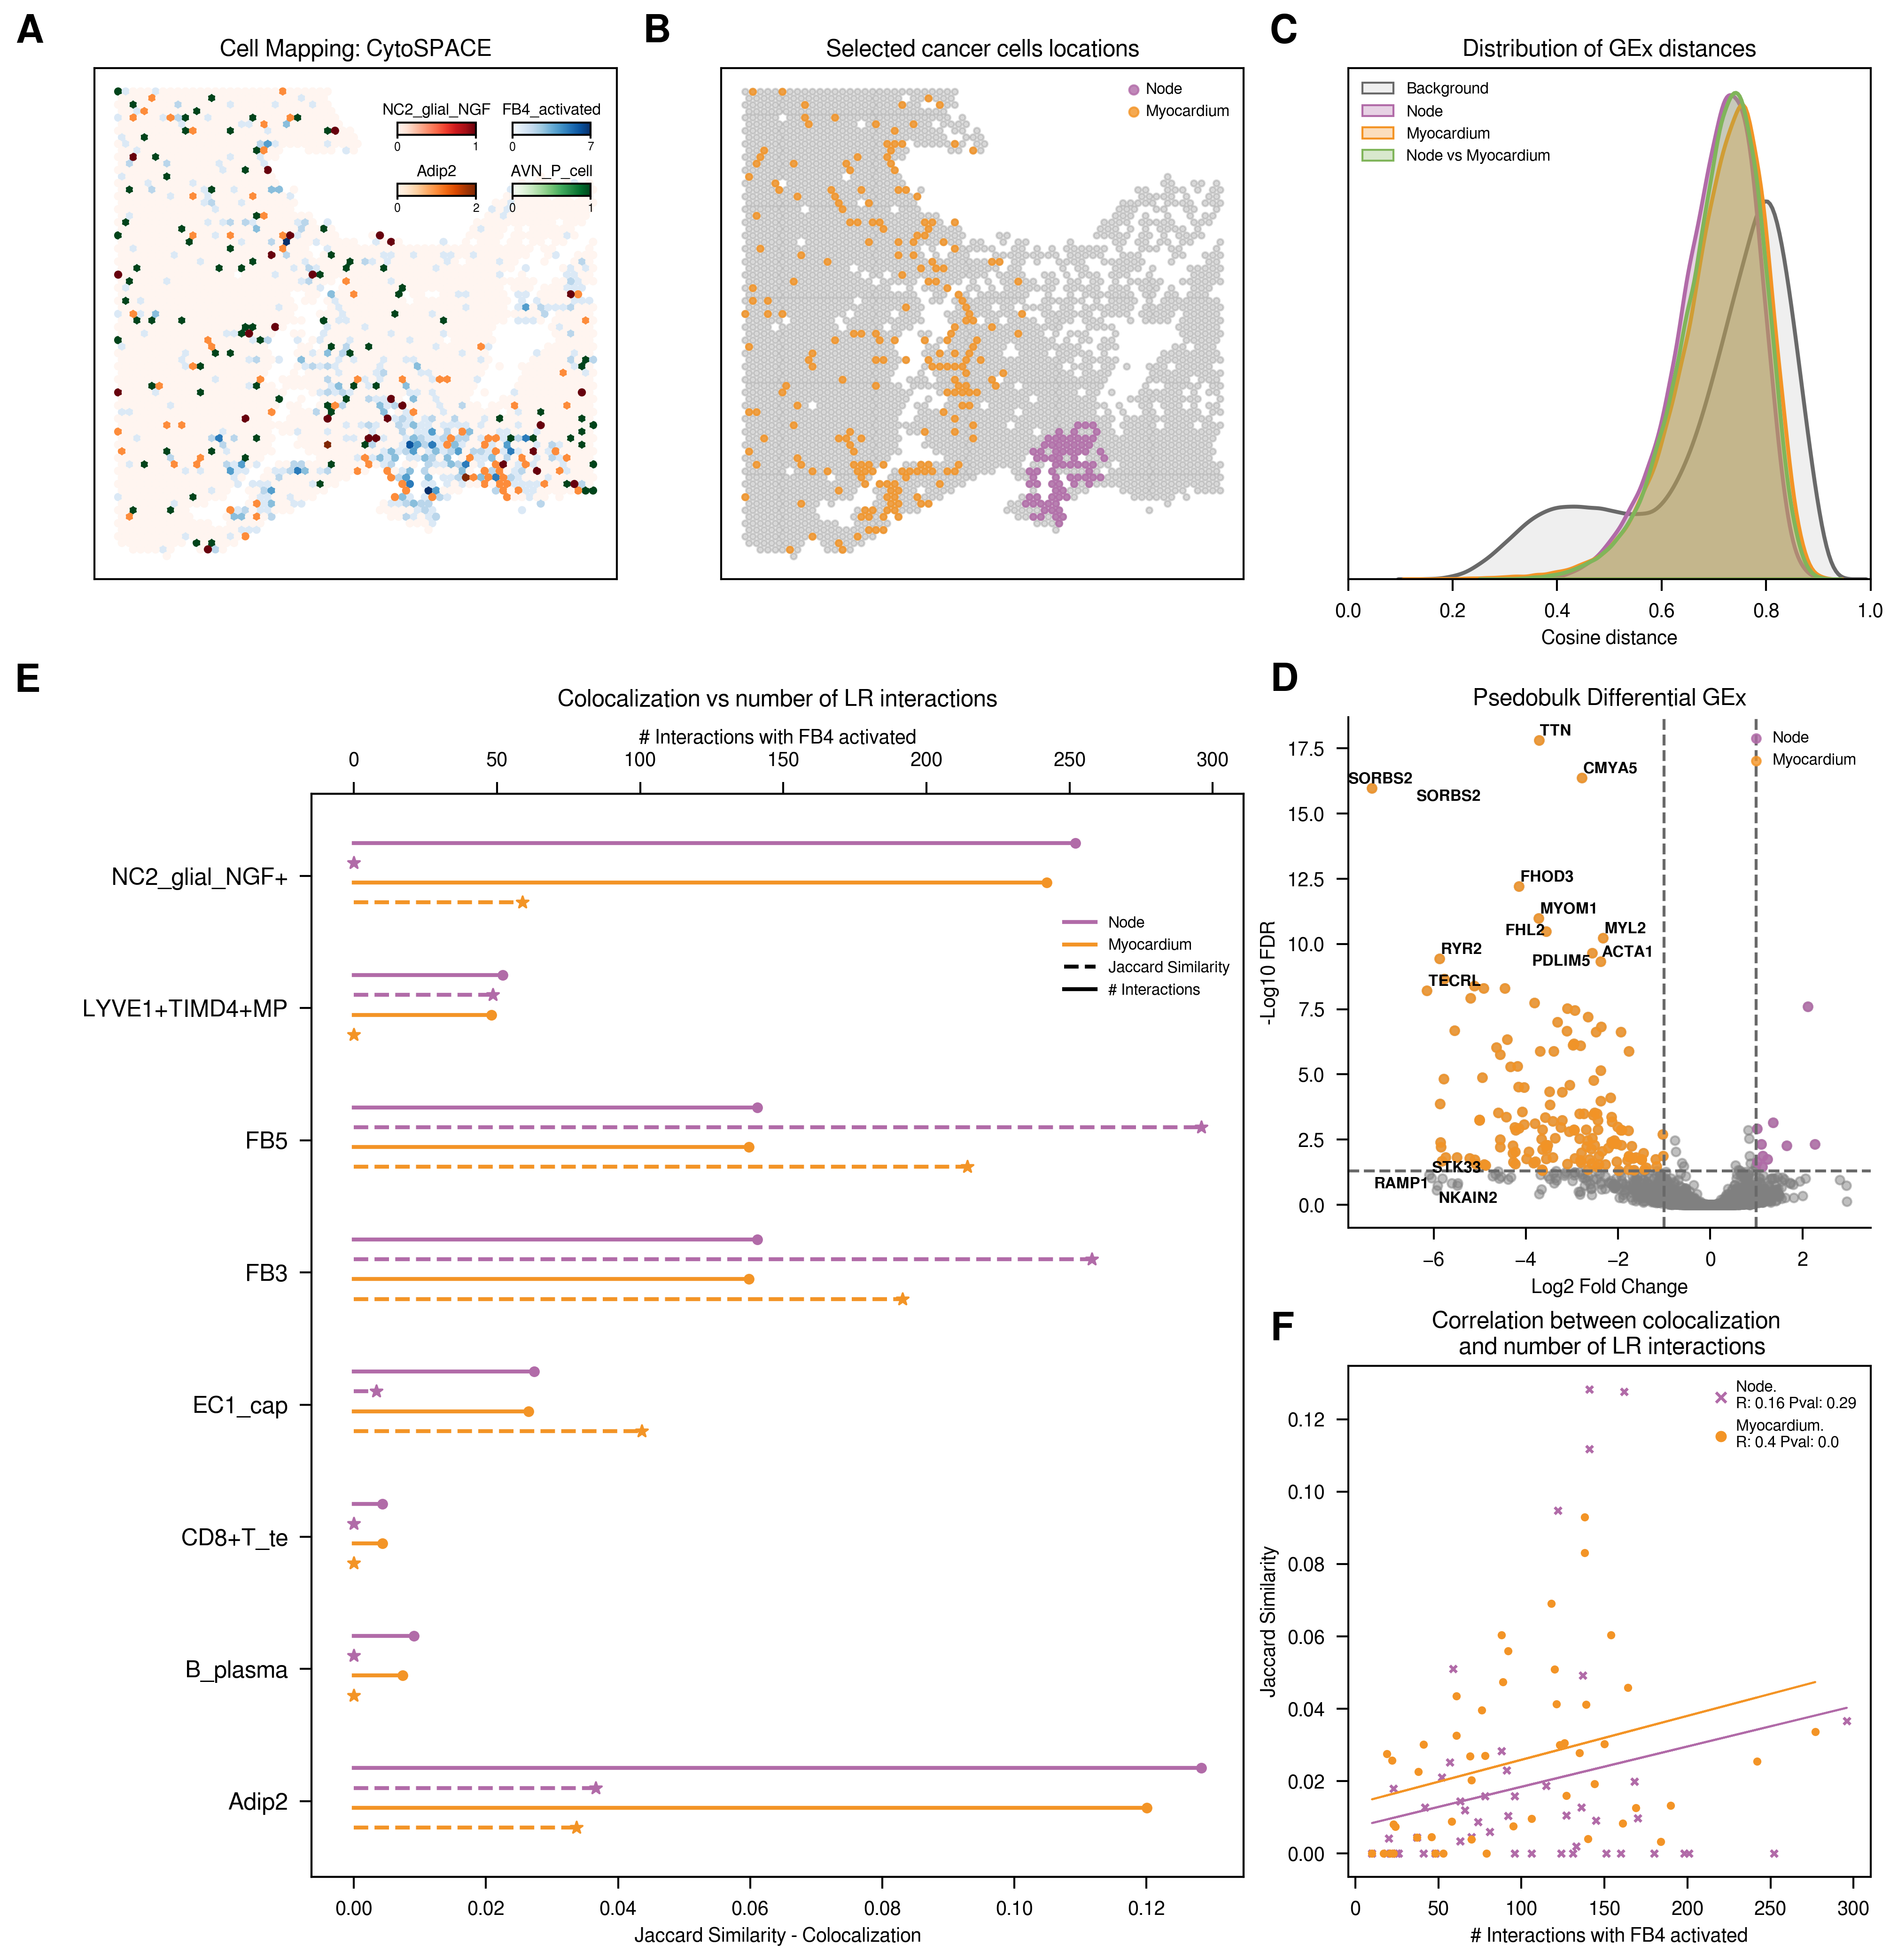

In [27]:
# Create a new figure with a custom grid for subplots
fig2 = plt.figure(figsize=(22, 17), dpi=300)

# Create a GridSpec with an uneven layout
gs2 = gridspec.GridSpec(3, 4, figure=fig2, hspace=0.27)

# First row - 3 plots
ax1 = fig2.add_subplot(gs2[0, :1]) # Span 1 column
ax1.text(-0.15, 1.05, 'A', transform=ax1.transAxes, size=20, weight='bold')
ax2 = fig2.add_subplot(gs2[0, 1:2]) # Span 1 column
ax2.text(-0.15, 1.05, 'B', transform=ax2.transAxes, size=20, weight='bold')
ax3 = fig2.add_subplot(gs2[0, 2:3]) # Span 2 columns
ax3.text(-0.15, 1.05, 'C', transform=ax3.transAxes, size=20, weight='bold')


# Second row - 1 tall plot and 2 plots one on top of the other
ax4 = fig2.add_subplot(gs2[1:, :2]) # Span 2 rows and 2 columns for the tall plot
ax4.text(-0.319, 1.0938, 'E', transform=ax4.transAxes, size=20, weight='bold')
ax5 = fig2.add_subplot(gs2[1, 2:3]) # Span 2 columns for the top small plot
ax5.text(-0.15, 1.05, 'D', transform=ax5.transAxes, size=20, weight='bold')
ax6 = fig2.add_subplot(gs2[2, 2:3]) # Span 2 columns for the bottom small plot
ax6.text(-0.15, 1.05, 'F', transform=ax6.transAxes, size=20, weight='bold')

#####################################################################################################################################################
#####################################################################################################################################################
####################### MAPPING #####################################################################################################################
#####################################################################################################################################################
#####################################################################################################################################################

abundances_figure(abundances, coords, ax1, query_cells, 'Cell Mapping: CytoSPACE', colorbar = True, colorbar_bounds = colorbar_bounds)

#####################################################################################################################################################
#####################################################################################################################################################
####################### DISTANCES ###################################################################################################################
#####################################################################################################################################################
#####################################################################################################################################################


sns.kdeplot(all_cosine, label = 'Background', color = 'dimgray', ax = ax3, fill=True, alpha=.1,  linewidth=2)
sns.kdeplot(loc1_cosine, label = 'Node', color = '#B16BA8' ,ax = ax3, fill=True, alpha=.3, linewidth=2)
sns.kdeplot(loc2_cosine, label = 'Myocardium', color = '#F39426', ax = ax3, fill=True,  alpha=.3,linewidth=2)
sns.kdeplot(np.concatenate(vs_cosine), label = 'Node vs Myocardium', color = '#80b55a', fill=True, alpha = 0.3,linewidth=2, ax=ax3)


legend = ax3.legend(frameon = False, fontsize = label_size, loc= 'upper left')
for handle in legend.legend_handles:
    handle.set_linewidth(1) 

ax3.set_xlim(0,1)
ax3.set_xlabel('Cosine distance', fontsize=labelout_size)
ax3.set_ylabel('')
ax3.set_yticks([])
ax3.tick_params(axis='both', which='major', labelsize=labelout_size)
ax3.set_title('Distribution of GEx distances', fontsize=title_size)


#####################################################################################################################################################
#####################################################################################################################################################
####################### VOLCANO #####################################################################################################################
#####################################################################################################################################################
#####################################################################################################################################################

ax5.scatter(log_fold_changes, neg_log_p_values, color='grey', alpha=0.5, s = 20)
ax5.scatter(log_fold_changes[(log_fold_changes > 1) & (neg_log_p_values > -np.log10(0.05))], 
            neg_log_p_values[(log_fold_changes > 1) & (neg_log_p_values > -np.log10(0.05))], 
            color='#B16BA8', alpha=0.8, s= 20, label = 'Node')
ax5.scatter(log_fold_changes[(log_fold_changes < -1) & (neg_log_p_values > -np.log10(0.05))], 
            neg_log_p_values[(log_fold_changes < -1) & (neg_log_p_values > -np.log10(0.05))], 
            color='#F39426', alpha=0.8, s= 20 , label = 'Myocardium')

texts = []
for index, row in top_pval.iterrows():
        texts.append(ax5.text(row['log2FoldChange'], -np.log10(row['padj']), row['symbol'], fontsize=label_size, fontweight = 'bold'))

for index, row in top_all.iterrows():
        if row['symbol'] not in top_pval.index:
                texts.append(ax5.text(row['log2FoldChange'], -np.log10(row['padj']), row['symbol'], fontsize=label_size, fontweight = 'bold'))

adjust_text(texts, ax=ax5)


# Highlighting the threshold line for p-value
ax5.axhline(y=-np.log10(0.05), color='dimgray', linestyle='--')
ax5.axvline(x=1, color='dimgray', linestyle='--')
ax5.axvline(x=-1, color='dimgray', linestyle='--')


# Add labels and title
ax5.set_xlabel('Log2 Fold Change', fontsize=labelout_size)
ax5.set_ylabel('-Log10 FDR', fontsize=labelout_size)
ax5.set_title('Psedobulk Differential GEx', fontsize=title_size)

ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)

ax5.tick_params(axis='both', which='major', labelsize=labelout_size)
ax5.legend(frameon = False, fontsize = label_size, handlelength=0.5, loc = 'upper right')

#####################################################################################################################################################
#####################################################################################################################################################
####################### INTERACTIONS ################################################################################################################
#####################################################################################################################################################
#####################################################################################################################################################
# Create the plot
# Plot the normalized data as horizontal lolliplots


for i, row in data.iterrows():

    ax4.plot([0, row['JS_loc2']], [i, i], color='#F39426', lw=2, ls = '--', zorder=10)
    ax4.scatter([row['JS_loc2']], [i], color='#F39426', s=40, marker='*', zorder=10)

    ax4.plot([0, row['JS_loc1']], [i + 0.3, i + 0.3], color='#B16BA8', lw=2, ls = '--', zorder=10)
    ax4.scatter([row['JS_loc1']], [i + 0.3], color='#B16BA8', s=40,  marker='*', zorder=10)
    
# Create a second x-axis to represent the interactions with cancer cells
ax42 = ax4.twiny() 

# Plot the number of significant LR interctions as horizontal lolliplots
for i, row in data.iterrows():
    ax42.plot([0, row['inter_loc2']], [i + 0.15, i + 0.15], color='#F39426', lw=2, zorder=10)
    ax42.scatter([row['inter_loc2']], [i + 0.15], color='#F39426', s=20, zorder=10)

    ax42.plot([0, row['inter_loc1']], [i + 0.45, i + 0.45], color='#B16BA8', lw=2, zorder=10)
    ax42.scatter([row['inter_loc1']], [i + 0.45], color='#B16BA8', s=20, zorder=10)


ax4.set_xlabel('Jaccard Similarity - Colocalization',  fontsize=labelout_size)
ax42.set_xlabel('# Interactions with FB4 activated',  fontsize=labelout_size)

ax4.tick_params(axis='both', labelsize=labelout_size)
ax4.set_yticks([0.2, 1.2, 2.2, 3.2, 4.2, 5.2, 6.2, 7.2], data['cells'], fontsize = title_size)
ax4.set_title('Colocalization vs number of LR interactions', fontsize=title_size, y = 1.07)

legend_elements = [
    Line2D([0], [0], color='#B16BA8', lw=2, label='Node'),
    Line2D([0], [0], color='#F39426', lw=2, label='Myocardium'),
    Line2D([0], [0], color='black', lw=2, ls='--', label='Jaccard Similarity'),
    Line2D([0], [0], color='black', lw=2, label='# Interactions')
]
ax4.legend(handles=legend_elements, fontsize=label_size, frameon = False, loc = 'upper right', bbox_to_anchor=(1, 0.9))

pos = ax4.get_position()
pos.x0 = pos.x0 + 0.07
pos.y1 = pos.y1 - 0.032
ax4.set_position(pos)


#####################################################################################################################################################
#####################################################################################################################################################
####################### LOCATION ####################################################################################################################
#####################################################################################################################################################
#####################################################################################################################################################


background_coords = cyto_cell2spot.drop_duplicates('SpotID')[['SpotID', 'row', 'col']]

xs_b = background_coords.row.values
ys_b = background_coords.col.values

xl = cyto_cell2spot[cyto_cell2spot.SpotID.isin(loc2_spots)].drop_duplicates('SpotID')[['SpotID', 'row', 'col']].row.values
yl = cyto_cell2spot[cyto_cell2spot.SpotID.isin(loc2_spots)].drop_duplicates('SpotID')[['SpotID', 'row', 'col']].col.values

xr = cyto_cell2spot[cyto_cell2spot.SpotID.isin(loc1_spots)].drop_duplicates('SpotID')[['SpotID', 'row', 'col']].row.values
yr = cyto_cell2spot[cyto_cell2spot.SpotID.isin(loc1_spots)].drop_duplicates('SpotID')[['SpotID', 'row', 'col']].col.values

ax2.scatter(ys_b, -xs_b, s=10, c = 'grey', alpha = 0.3)
ax2.scatter(yr, -xr, s=10, c = '#B16BA8', alpha = 0.8, label = 'Node')
ax2.scatter(yl, -xl, s=10, c = '#F39426', alpha = 0.8, label = 'Myocardium')
ax2.set_title('Selected cancer cells locations', fontsize=title_size)
ax2.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
ax2.legend(frameon = False,  markerscale=1.5,handlelength=0.5,  handletextpad=0.5, fontsize = label_size, loc = 'upper right')


#####################################################################################################################################################
#####################################################################################################################################################
####################### CORRELATION #################################################################################################################
#####################################################################################################################################################
#####################################################################################################################################################

ax6.scatter(data_correlation['inter_loc1'], data_correlation['JS_loc1'], c = '#B16BA8', s = 12, marker='x', label='Node. \nR: %s Pval: %s' % (round(spearmanr(data_correlation['inter_loc1'], data_correlation['JS_loc1'])[0], 2), round(spearmanr(data_correlation['inter_loc1'], data_correlation['JS_loc1'])[1], 2)))
ax6.scatter(data_correlation['inter_loc2'], data_correlation['JS_loc2'], c ='#F39426', s=10 , label='Myocardium. \nR: %s Pval: %s' % (round(spearmanr(data_correlation['inter_loc2'], data_correlation['JS_loc2'])[0], 2), round(spearmanr(data_correlation['inter_loc2'], data_correlation['JS_loc2'])[1], 2)))
# Calculate and plot regression line for 'inter_loc1' vs. 'JS_loc1'
m_red, b_red = np.polyfit(data_correlation['inter_loc1'], data_correlation['JS_loc1'], 1)
ax6.plot(data_correlation['inter_loc1'], m_red * data_correlation['inter_loc1'] + b_red, color='#B16BA8', linewidth=1)
# Calculate and plot regression line for 'inter_loc2' vs. 'JS_loc2'
m_orange, b_orange = np.polyfit(data_correlation['inter_loc2'], data_correlation['JS_loc2'], 1)
ax6.plot(data_correlation['inter_loc2'], m_orange * data_correlation['inter_loc2'] + b_orange, color='#F39426', linewidth=1)

ax6.set_ylabel('Jaccard Similarity', fontsize=labelout_size)
ax6.set_xlabel('# Interactions with FB4 activated', fontsize=labelout_size)
ax6.tick_params(axis='both', which='major', labelsize=labelout_size)
ax6.legend(frameon = False, fontsize = label_size, loc = 'upper right', markerscale=1.5,handlelength=0.5,  handletextpad=0.7)
ax6.set_title('Correlation between colocalization \n and number of LR interactions', fontsize=title_size)


plt.savefig(global_path+'grid_figure_AVN.svg',format='svg', dpi=300 , bbox_inches='tight')
plt.savefig(global_path+'grid_figure_AVN.png',format='png', dpi=300, facecolor='white', edgecolor='none', bbox_inches='tight')
